# Day 11: Seating System 

https://adventofcode.com/2020/day/11#part2

## Part 1

In [5]:
import numpy as np
import matplotlib.pylab as plt

FLOOR = -1
EMPTY = 0
OCCUP = 1

def getSeatMaps(filename):
    with open(filename) as f:
        lines = [ l.strip('\n') for l in f.readlines() ]
    nr = len(lines)
    nc = len(lines[0])
    floor = np.zeros((nr,nc),dtype=int)
    iniseats = np.zeros((nr,nc),dtype=int)
    ir = 0
    ic = 0
    for r in lines:
        for c in r:
            if c=="L":
                iniseats[ir][ic] = EMPTY
            elif c=="#":
                iniseats[ir][ic] = OCCUP
            else:
                iniseats[ir][ic] = FLOOR
                floor[ir][ic] = OCCUP
            ic += 1
        ic = 0
        ir += 1
    return iniseats, floor

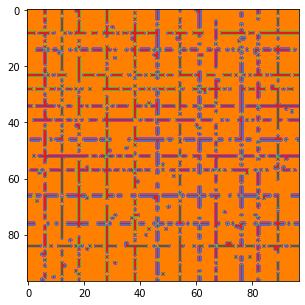

In [48]:
#filename = "data/day11text0.txt"
filename = "data/input11.txt"

iniseats, floor = getSeatMaps(filename)

_cmap = plt.cm.Set1

fig = plt.figure(figsize=(5,5))
plt.imshow(iniseats,cmap=_cmap,vmin=-1,vmax=1)

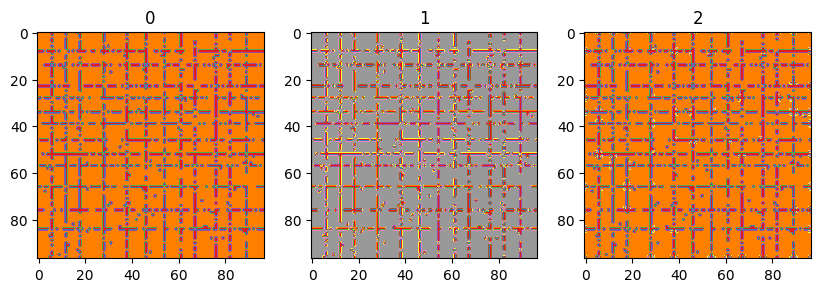

In [49]:
def evolveSeats(seats,floor):
    (nr,nc) = np.shape(seats)
    newseats = np.zeros((nr,nc),dtype=int)
    for ir in range(nr):
        for ic in range(nc):
            if floor[ir][ic]:
                newseats[ir][ic] = FLOOR
                continue
            else:
                occupied = 0
                for jr in range(ir-1,ir+2):
                    for jc in range(ic-1,ic+2):
                        if jr<0 or jr>=nr or jc<0 or jc>=nc or \
                           ( jr == ir and jc==ic ) or \
                           floor[jr][jc] :
                            continue
                        else:
                            occupied += seats[jr][jc]
                if seats[ir][ic] == EMPTY:
                    if not occupied:
                        newseats[ir][ic] = OCCUP
                    else:
                        newseats[ir][ic] = EMPTY
                elif seats[ir][ic] == OCCUP:
                    if occupied>=4:
                        newseats[ir][ic] = EMPTY
                    else:
                        newseats[ir][ic] = OCCUP
    return newseats

oldseats = np.copy(iniseats)
newseats = evolveSeats(oldseats,floor)
newseats2 = evolveSeats(newseats,floor)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,3,1)
f = plt.imshow(oldseats,cmap=_cmap,vmin=-1,vmax=1)
f.axes.set_title("0")

plt.subplot(1,3,2)
f = plt.imshow(newseats,cmap=_cmap,vmin=-1,vmax=1)
f.axes.set_title("1")

plt.subplot(1,3,3)
f = plt.imshow(newseats2,cmap=_cmap,vmin=-1,vmax=1)
f.axes.set_title("2")

plt.show()

Occupied seats = 2427
Execution time = 6.31 s


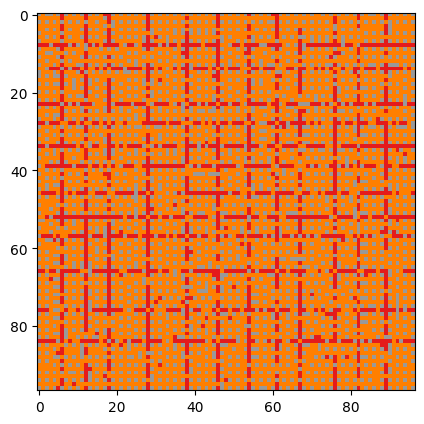

In [83]:
oldseats = np.copy(iniseats)
nfloor = floor.sum()
noccupnew = -1
noccup = oldseats.sum()+nfloor

from timeit import default_timer as timer
start = timer()

from celluloid import Camera
fig = plt.figure(figsize=(5,5),dpi=100)
camera = Camera(fig)

while( noccup!=noccupnew ):
    #
    plt.imshow(oldseats,cmap=_cmap)
    camera.snap()
    #
    noccup = oldseats.sum()+nfloor    
    newseats = evolveSeats(oldseats,floor)
    noccupnew = newseats.sum()+nfloor
    #print(noccup,noccupnew)    
    oldseats = np.copy(newseats)

print("Occupied seats =",noccup)
    
stop = timer() 
print("Execution time = %3.2f s"%((stop - start)))

In [84]:
print("Saving animation... ",end="")
anim = camera.animate(blit=True)
anim.save('visualisation/day11animationPart1.gif', writer='imagemagick')
print("Animation saved.")

Saving animation... Animation saved.


![Part1](./visualisation/day11animationPart1.gif "Part 1")

## Part 2

"Instead of considering just the eight immediately adjacent seats, consider the **first** seat in each of those eight directions"

Idea: cache the coordinates of all visible seats from each seat in the matrix, in order to only check those without having to search for the coordinate each time I evolve the matrix and have to count how many of them are occupied to change current seat status.

In [51]:
def getSeatPositions(seats,ir,ic):
    (nr,nc) = np.shape(seats)
    # get the coordinates of the first visible seat in each of the 8 directions from seat at (ir,ic)
    # save in vector to be cached and used later
    visible = []
    # directions
    # N
    jc = ic
    for jr in range(ir-1,-1,-1):
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    # S
    jc = ic
    for jr in range(ir+1,nr):
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    # W
    jr = ir
    for jc in range(ic-1,-1,-1):
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    # E
    jr = ir
    if ic < nc-1:
        for jc in range(ic+1,nc):
            if seats[jr][jc] != FLOOR:
                visible.append((jr,jc))
                break          
    # NW
    jc = ic
    for jr in range(ir-1,-1,-1): # move N
        jc -= 1 # move W
        if jc < 0:
            break
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    # NE
    jc = ic
    for jr in range(ir-1,-1,-1): # move N
        jc += 1 # move E
        if jc >= nc:
            break
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    # SW
    jc = ic
    for jr in range(ir+1,nr): # move S
        jc -= 1 # move W
        if jc < 0:
            break
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    # SE
    jc = ic
    for jr in range(ir+1,nr): # move S
        jc += 1 # move E
        if jc >= nc:
            break
        if seats[jr][jc] != FLOOR:
            visible.append((jr,jc))
            break
    return visible

def cacheVisibleSeats(iniseats):
    (nr,nc) = np.shape(iniseats)
    # I want to save the list of seat coordinates in a matrix:
    # first turn list into a ufunc that takes no arguments and returns a single empty list, 
    # then apply it to an empty nrxnc array of object type.
    seatcache = np.frompyfunc(list, 0, 1)(np.empty((nr,nc), dtype=object))
    for ir in range(nr):
        for ic in range(nc):
            if iniseats[ir][ic] != FLOOR:
                v = getSeatPositions(iniseats,ir,ic)
                seatcache[ir][ic] = v
    return seatcache

0
[(1, 3), (8, 3), (4, 2), (4, 8), (2, 1), (0, 7), (7, 0), (5, 4)]


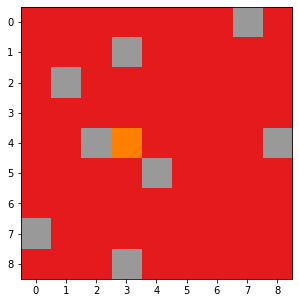

In [52]:
iniseats, floor = getSeatMaps("data/day11text1.txt")

fig = plt.figure(figsize=(5,5))
plt.imshow(iniseats,cmap=_cmap,vmin=-1,vmax=1)

print(iniseats[4][3]) # r, c
print(getSeatPositions(iniseats,4,3))

[(7, 8), (9, 6), (9, 9), (8, 7), (8, 9)]


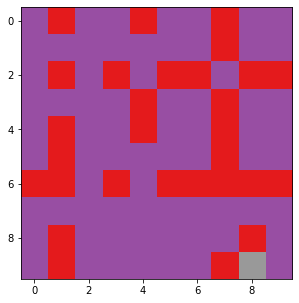

In [53]:
iniseats, floor = getSeatMaps("data/day11text0.txt")

seatcache = cacheVisibleSeats(iniseats)
iniseats[9][8] = 2
print(seatcache[9][8])

fig = plt.figure(figsize=(5,5))
plt.imshow(iniseats,cmap=_cmap)

In [54]:
def evolveSeats2(seats,floor,seatcache):
    (nr,nc) = np.shape(seats)
    newseats = np.zeros((nr,nc),dtype=int)
    for ir in range(nr):
        for ic in range(nc):
            if floor[ir][ic]:
                newseats[ir][ic] = FLOOR
                continue
            else:
                occupied = 0
                for (jr,jc) in seatcache[ir][ic]: # check status of visible seats using chached coordinates
                    occupied += seats[jr][jc]
                if seats[ir][ic] == EMPTY:
                    if not occupied:
                        newseats[ir][ic] = OCCUP
                    else:
                        newseats[ir][ic] = EMPTY
                elif seats[ir][ic] == OCCUP:
                    if occupied>=5:
                        newseats[ir][ic] = EMPTY
                    else:
                        newseats[ir][ic] = OCCUP
    return newseats

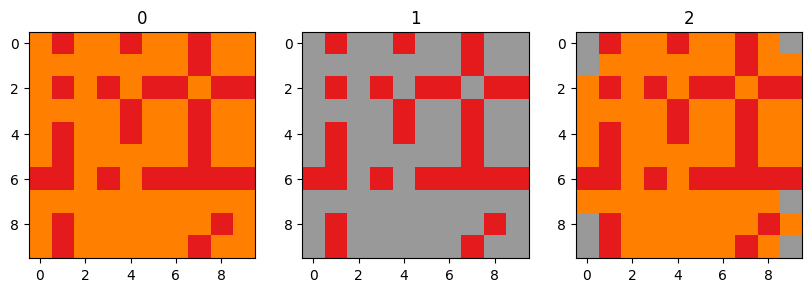

In [58]:
iniseats, floor = getSeatMaps("data/day11text0.txt")
seatcache = cacheVisibleSeats(iniseats)

oldseats = np.copy(iniseats)
newseats = evolveSeats2(oldseats,floor,seatcache)
newseats2 = evolveSeats2(newseats,floor,seatcache)

fig = plt.figure(figsize=(10,3), dpi=100)
plt.subplot(1,3,1)
f = plt.imshow(oldseats,cmap=_cmap,vmin=-1,vmax=1)
f.axes.set_title("0")

plt.subplot(1,3,2)
f = plt.imshow(newseats,cmap=_cmap,vmin=-1,vmax=1)
f.axes.set_title("1")

plt.subplot(1,3,3)
f = plt.imshow(newseats2,cmap=_cmap,vmin=-1,vmax=1)
f.axes.set_title("2")

plt.show()

Occupied seats = 2199
Execution time = 3.56 s


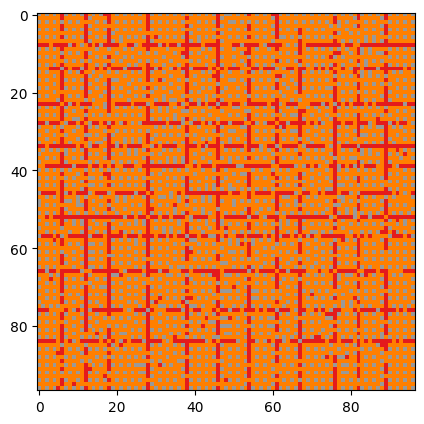

In [86]:
#iniseats, floor = getSeatMaps("data/day11text0.txt")
iniseats, floor = getSeatMaps("data/input11.txt")

seatcache = cacheVisibleSeats(iniseats)
oldseats = np.copy(iniseats)
nfloor = floor.sum()
noccupnew = -1
noccup = oldseats.sum()+nfloor

from timeit import default_timer as timer
start = timer()

from celluloid import Camera
fig = plt.figure(figsize=(5,5),dpi=100)
camera = Camera(fig)

while( noccup!=noccupnew ):
    #
    plt.imshow(oldseats,cmap=_cmap)
    camera.snap()
    #
    noccup = oldseats.sum()+nfloor    
    newseats = evolveSeats2(oldseats,floor,seatcache)
    noccupnew = newseats.sum()+nfloor  
    oldseats = np.copy(newseats)

print("Occupied seats =",noccup)
    
stop = timer() 
print("Execution time = %3.2f s"%((stop - start)))

In [87]:
print("Saving animation... ",end="")
anim = camera.animate(blit=True)
anim.save('visualisation/day11animationPart2.gif', writer='imagemagick')
print("Animation saved.")

Saving animation... Animation saved.


![Part2](./visualisation/day11animationPart2.gif "Part 2")